In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import seaborn as sns
import nltk
import networkx as nx
import tkinter as tk
from tkinter import scrolledtext
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import manhattan_distances
from sklearn.metrics.pairwise import cosine_similarity
import arabic_reshaper
from arabic_reshaper import reshape
from bidi.algorithm import get_display


In [2]:
excel = pd.read_excel('C:/Users/DELL/Desktop/mid dm/Complaints dataset.xlsx')

df = pd.DataFrame(excel)

In [3]:
df.head(10)

,OFFER_NAME,CUSTOMER_TYPE,COMPLAINT_TYPE,PRODUCT,CASE_LEVEL_1,CASE_LEVEL_2,CASE_LEVEL_3,CUSTOMER_GROUP,CURRENT_STATUS,ESCALATION_FLAG,...,CLOSE_GROUP,AGE_BRACKET,ACTUAL_COMPLAINT,CALLBACK_MECHANISM,RESOLUTION,RESOLUTION_DESCRIPTION,CASE_DESC,OPEN_GR,Unnamed: 22,Unnamed: 23
0,FTTH Home,CBU,Technical,Internet,Technical complaint,TC_INTERNET_CONFIGURATION,SNW-FTTH - WAN configuration / Tools,FTTH Home,Resolved,No,...,NaN,1,User Not Filled,NaN,NaN,NaN,إعادة برمجة من النظامby Sultan,NaN,NaN,NaN
1,NaN,CBU,Technical,Mobile,Technical complaint,TC_INTERNET_CONNEXION,4G - Frequent Disconnection,NaN,Resolved,Yes,...,Mobile_BO,1,Actual Complaint,SMS,Coverage script was sent to the customer,The customer should pay TF + all due amounts i...,عدم التصفح وسوء الخدمه والرجاء اتخاذ قرار ...,System Administrator,NaN,NaN
2,Super 4G on the go 100GB new,CBU,Commercial,Mobile,Commercial claim,CC_Offers,Embedded Bundle - Didn't Get The Monthly Bundles,Family Mobile-IEW,Resolved,Yes,...,Mobile_BO,1,Actual Complaint,SMS,IEW offer -no link,the line is active now & linked & getting the ...,Activation date Sep 22 2022 لم يتم اضافة ا...,NaN,NaN,NaN
3,Pro Bitstream,CBU,Technical,Internet,Technical complaint,TC_Network,SNW-ADSL-Individual fault,Internet SME,Resolved,No,...,NaN,1,User Not Filled,NaN,NaN,NaN,GAIA,NaN,NaN,NaN
4,FTTH Home,CBU,Technical,Internet,Technical complaint,TC_Network,SNW-FTTH - Down interrupted,FTTH Home,Resolved,No,...,NaN,1,User Not Filled,NaN,NaN,NaN,Interrupted,NaN,NaN,NaN
5,FTTH Home,CBU,Technical,Internet,Technical complaint,TC_Network,SNW-FTTH - Down interrupted,FTTH Home,Resolved,No,...,NaN,1,User Not Filled,NaN,NaN,NaN,Interrupted,NaN,NaN,NaN
6,FTTH Home,CBU,Technical,Internet,Technical complaint,TC_Network,SNW-FTTH - Down interrupted,FTTH Home,Resolved,No,...,NaN,1,User Not Filled,NaN,NaN,NaN,Interrupted,NaN,NaN,NaN
7,FTTH Home,CBU,Technical,Internet,Technical complaint,TC_INTERNET_CONFIGURATION,SNW-FTTH - Never connected,FTTH Home,Resolved,Yes,...,NaN,1,Actual Complaint,Phone,NEVER CONNECTED,sent by gaia after tried with customer from hi...,Never connected ONT UnknownCONTACT NUMBER ...,CBU - CC 1st Layer,NaN,NaN
8,FTTH Home,CBU,Technical,Internet,Technical complaint,TC_INTERNET_CONFIGURATION,SNW-FTTH - Never connected,FTTH Home,Resolved,Yes,...,F&I_BO,1,Actual Complaint,Phone,out of home //customer informed the steps to a...,out of home //customer informed the steps to a...,Never connected ONTUnknown07994746460790205560,CBU - CC 1st Layer,NaN,NaN
9,FTTH Home,CBU,Technical,Internet,Technical complaint,TC_INTERNET_CONFIGURATION,SNW-FTTH - Never connected,FTTH Home,Resolved,No,...,NaN,1,User Not Filled,NaN,NaN,NaN,Never connected ONTاعادة الاتصال من جانب ال...,NaN,NaN,NaN


In [4]:
df['CASE_DESC'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 50000 entries, 0 to 49999
Series name: CASE_DESC
Non-Null Count  Dtype 
--------------  ----- 
50000 non-null  object
dtypes: object(1)
memory usage: 390.8+ KB


In [5]:
df['CASE_DESC'].head(15)

0                        إعادة برمجة من النظامby Sultan
1         عدم التصفح وسوء الخدمه والرجاء اتخاذ قرار ...
2        Activation date Sep 22 2022  لم يتم اضافة ا...
3                                                  GAIA
4                                           Interrupted
5                                           Interrupted
6                                           Interrupted
7        Never connected ONT  UnknownCONTACT NUMBER ...
8        Never connected ONTUnknown07994746460790205560
9        Never connected ONTاعادة الاتصال من جانب ال...
10       Never connected ONTالمشترك رافع السرعه  وتم...
11       Never connected ONTالمشترك لا يستطيع الدخول...
12       Never connected ONTمشكلة برمجية على الموديم...
13                                   Reduced robustness
14                                   Reduced robustness
Name: CASE_DESC, dtype: object

In [6]:
counts = df['CASE_DESC'].value_counts()
df = df[df['CASE_DESC'].isin(counts[counts <= 4].index)]

In [7]:
def single_word(row):
    return len(row.split()) > 1
df = df[df['CASE_DESC'].apply(single_word)]

In [8]:
df = df[~df['CASE_DESC'].astype(str).str.count('\d+').gt(0)]

In [9]:
def preprocessing(text):

    #https://docs.python.org/3/library/re.html
    
    text = re.sub(r'[^\x00-\x7F\u0600-\u06FF]+', ' ', text)

    text = re.sub('أ', 'ا', text)
    text = re.sub('إ', 'ا', text)
    text = re.sub('ا', 'ا', text)
    text = re.sub('ٱ', 'ا', text)

    text = re.sub('لإ', 'لا', text)
    text = re.sub('لآ', 'لا', text)
    text = re.sub('لأ', 'لا', text)
    text = re.sub('لا', 'لا', text)

    text = re.sub('ٌ', '', text)
    text = re.sub('ُ', '', text)
    text = re.sub('ً', '', text)
    text = re.sub('َ', '', text)
    text = re.sub('ٍ', '', text)
    text = re.sub('ِ', '', text)
    text = re.sub('ّ', '', text)
    text = re.sub('ْ', '', text)
    
    text = re.sub('ئ', 'ء', text)
    text = re.sub('ؤ', 'ء', text)
    text = re.sub('گ', 'ج', text)

    text = re.sub(r'\bال(\w+)', r'\1', text)
    text = re.sub(r'\bوال(\w+)', r'\1', text)
    text = re.sub(r'\bفال(\w+)', r'\1', text)
    text = re.sub(r'\bعال(\w+)', r'\1', text)
    text = re.sub(r'\bهال(\w+)', r'\1', text)
    text = re.sub(r'\bبال(\w+)', r'\1', text)
    
    #tokenize
    words = nltk.word_tokenize(text)
    
    #lowercase
    words = [word.lower() for word in words]

    #punctuation
    words = [word for word in words if re.match(r'\w', word)]

    #stopwords eng
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    #stopwords arb
    stop_words = set(stopwords.words('arabic'))
    words = [word for word in words if word not in stop_words]

    stemming = PorterStemmer()
    words = [stemming.stem(word) for word in words]

    processed_text = ' '.join(words)

    return processed_text

In [10]:
process = [preprocessing(row) for row in df['CASE_DESC']]

In [18]:
process = list(set(process))

In [12]:
df['CASE_DESC'].count()

4205

In [13]:
def distance_measures():
    Query = input_label.get()

    Query = preprocessing(Query)

    tfidf = TfidfVectorizer()
    tfidf_measure = tfidf.fit_transform(process + [Query])
    
    euclidean = pairwise_distances(tfidf_measure, metric='euclidean')

    manhattan = pairwise_distances(tfidf_measure, metric='manhattan')

    cosine_measure = cosine_similarity(tfidf_measure[-1], tfidf_measure [:-1]).flatten()

    cosine_df = pd.DataFrame({'Cosine Similarities:': cosine_measure})

    cosine_df = cosine_df.sort_values(by='Cosine Similarities:', ascending = False)

    similar_row_list = []

    text = 'best 5 queries\n'

    similar_row_indices = cosine_df.head(5).index

    similar_row_list = [process[index]for index in similar_row_indices]

    text = '\n'.join(f' {row}' for row in similar_row_list)

    info_text.set(text)

    return similar_row_list


In [14]:
def Directed_G():
    similar_row_list = distance_measures()

    graph = nx.DiGraph()

    for index in similar_row_list:
        word_split = index.split()
        for i in range(len(word_split) - 1):
            current_word1 = word_split[i]
            next_word1 = word_split[i + 1]

            display_current_word = get_display(reshape(current_word1))
            display_next_word = get_display(reshape(next_word1))

            graph.add_edge(display_current_word, display_next_word)

    dg_window = tk.Toplevel(root)
    dg_window.title('Directed Graph')
    
    plt.figure(figsize=(10, 6))
    
    pos = nx.circular_layout(graph)
    nx.draw(graph, pos, with_labels=True, font_weight='bold', font_size=8, node_size=1000, node_color='green', arrowsize=20)
    
    canvas = FigureCanvasTkAgg(plt.gcf(), master=dg_window)
    canvas_widget = canvas.get_tk_widget()
    canvas_widget.pack(side=tk.TOP, fill=tk.BOTH, expand=1)

    plt.show()

    degree_values = nx.degree_centrality(graph)
    betweenness_values = nx.betweenness_centrality(graph)
    closeness_values = nx.closeness_centrality(graph)

    centrality_window = tk.Toplevel(root)
    centrality_window.title("Centrality Measures")

    notepad = scrolledtext.ScrolledText(centrality_window, width=50, height=10, wrap=tk.WORD)

    notepad.insert(tk.INSERT, "Node\t\tDegree\tBetweenness\tCloseness\n")
    for node in graph.nodes():

        degree = degree_values.get(node, 0)
        betweenness = betweenness_values.get(node, 0)
        closeness = closeness_values.get(node, 0)

        notepad.insert(tk.END, f"{node}\t\t{degree:.4f}\t{betweenness:.4f}\t{closeness:.4f}\n")

    notepad.pack(expand=True, fill="both")
    centrality_window.mainloop()

In [15]:
def Weighted_G():
    similar_row_list = distance_measures()

    graph = nx.Graph()

    words = set()

    for index in [input_label.get()] + similar_row_list:
        word_split = index.split()
        reshaped_words = [get_display(reshape(word)) for word in word_split]
        words.update(reshaped_words)

    graph.add_nodes_from(words)

    for index in similar_row_list:
        word_split = index.split()
        reshaped_words = [get_display(reshape(word)) for word in word_split]
        unique_reshaped_words = set(reshaped_words)

        for current_word in unique_reshaped_words:
            for next_word in unique_reshaped_words:
                if current_word != next_word:
                    if graph.has_edge(current_word, next_word):
                        graph[current_word][next_word]['weight'] += 1
                    else:            
                        graph.add_edge(current_word, next_word, weight=0)

    wg_window = tk.Toplevel(root)
    wg_window.title("Weighted Graph")

    plt.figure(figsize=(10, 6))

    pos = nx.spring_layout(graph, k=0.5)
    edge_labels = {(current_word, next_word): weight['weight'] for current_word, next_word, weight in graph.edges(data=True)}
    nx.draw(graph, pos, with_labels=True, node_size=700, font_size=10, node_color = 'skyblue')
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)

    canvas = FigureCanvasTkAgg(plt.gcf(), master=wg_window)
    canvas_widget = canvas.get_tk_widget()
    canvas_widget.pack(side=tk.TOP, fill=tk.BOTH, expand=1)

    plt.show()

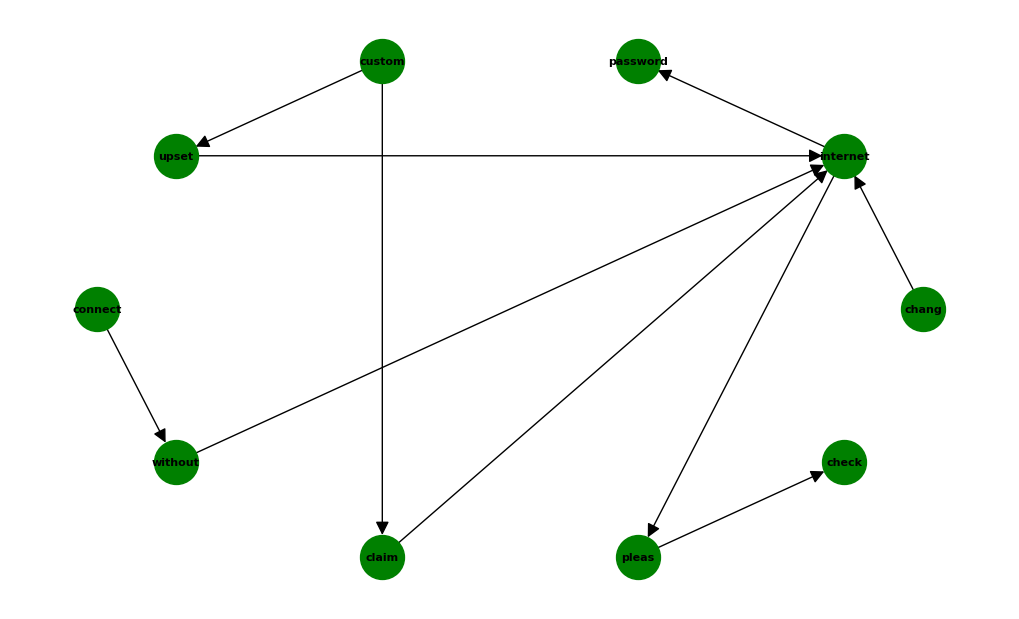

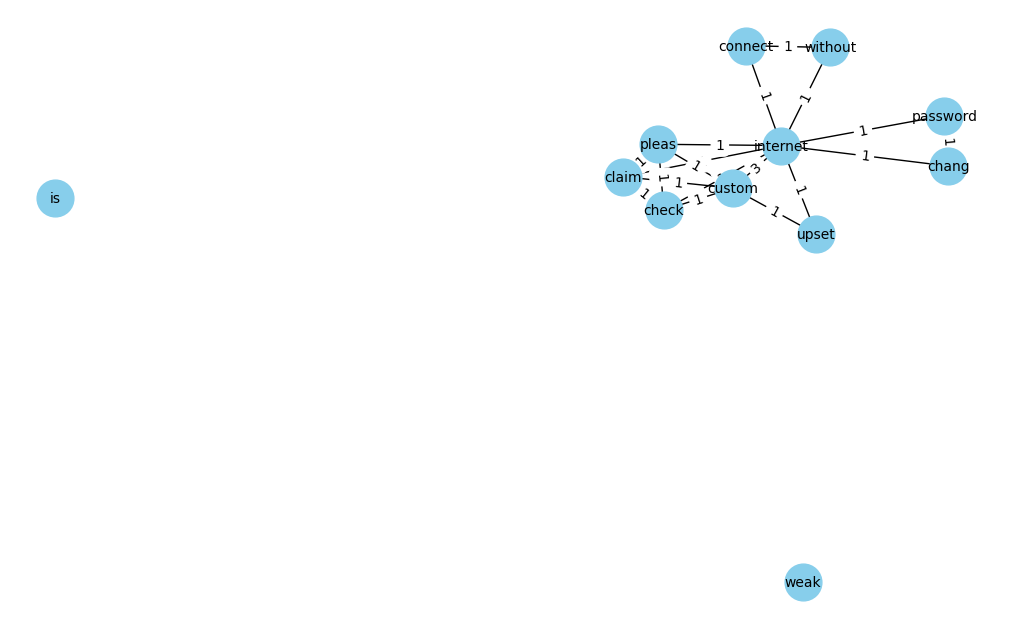

In [16]:
root = tk.Tk()
root.title('Similar complaints')

text_label = tk.Label(root, text = 'Input your query:')
text_label.pack(pady=10)

input_label = tk.Entry(root)
input_label.pack(pady=10)

similar_query_button = tk.Button(root, text = '5 similar queries', command = distance_measures)
similar_query_button.pack(pady=10)

info_text = tk.StringVar()
label_info = tk.Label(root, textvariable=info_text)
label_info.pack(pady=10)

open_dgraph_button = tk.Button(root, text = 'Open Directed Graph', command= Directed_G)
open_dgraph_button.pack(pady=10)

open_wgraph_button = tk.Button(root, text = 'Open Weighted Graph', command = Weighted_G)
open_wgraph_button.pack(pady=10)

root.mainloop()